## CIFAR-10 Classification with ResNet and PlainNet
This experiment follows the experiment setup from the paper "Deep Residual Learning for Image Recognition" by Kaiming He et al. The goal is to classify images from the CIFAR-10 dataset using both ResNet and PlainNet architectures for comparison.

## Setup and Imports

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

from model import ResNet, PlainNet

## Data Loading & Augmentation
The data augmentation is followed the paper "Deeply supervised nets." by Lee et al for training: 4 pixels are padded on each side, and random crops of size 32x32 are taken from the padded image or its horizontal flip. The test images are the original ones.

In [14]:
# CIFAR-10 mean and std (per channel)
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Data augmentation for testing
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Split sizes: 45,000 for training, 5,000 for validation
train_size = 45000
val_size = len(train_dataset) - train_size

# Set a fixed seed for reproducibility
train_subset, val_subset = random_split(train_dataset,
    [train_size, val_size], generator=torch.Generator().manual_seed(17))

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

## Model Setup

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = ResNet(in_channels=3, num_classes=10, filters=[16, 32, 64],
                blocks_per_stage=3).to(device)
plainnet = PlainNet(in_channels=3, num_classes=10, filters=[16, 32, 64],
                    blocks_per_stage=6).to(device)
# block_per_stage in PlainNet is two times equal to the one in ResNet
# because one residual block have 2 conv layers.

## Loss Function and Optimizer

In [16]:
criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9,
                             weight_decay=1e-4)
plainnet_optimizer = optim.SGD(plainnet.parameters(), lr=0.1, momentum=0.9,
                               weight_decay=1e-4)

## Learning Rate Scheduler

In [17]:
# Decay LR by 10 times at 32k and 48k iterations = 50 and 75 epochs (approx)
resnet_scheduler = optim.lr_scheduler.MultiStepLR(resnet_optimizer, milestones=[50, 75], gamma=0.1)
plainnet_scheduler = optim.lr_scheduler.MultiStepLR(plainnet_optimizer, milestones=[50, 75], gamma=0.1)

## Training and Evaluation functions

In [ ]:
def train(model, train_loader, criterion, optimizer, epoch, device, val_loader=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / total
    train_acc = 100. * correct / total

    print(f"[Train] Epoch {epoch} | Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")

    # Optional: evaluate on validation set
    val_loss, val_acc = None, None
    if val_loader:
        val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch, tag="Val")

    return train_loss, train_acc, val_loss, val_acc

def evaluate(model, loader, criterion, device, epoch=None, tag="Test"):
    model.eval()
    loss_total = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss_total += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = loss_total / total
    acc = 100. * correct / total

    if epoch is not None:
        print(f"[{tag}] Epoch {epoch} | Loss: {avg_loss:.4f} | Acc: {acc:.2f}%")
    else:
        print(f"[{tag}] | Loss: {avg_loss:.4f} | Acc: {acc:.2f}%")

    return avg_loss, acc

## Main running loop

In [19]:
num_epochs = 100

In [20]:
resnet_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# --- Train ResNet ---
for epoch in range(1, num_epochs + 1):
    r_loss, r_acc, r_val_loss, r_val_acc = train(
        resnet, train_loader, criterion, resnet_optimizer, epoch, device, val_loader
    )
    resnet_scheduler.step()  # LR scheduler for ResNet

    resnet_history['train_loss'].append(r_loss)
    resnet_history['train_acc'].append(r_acc)
    resnet_history['val_loss'].append(r_val_loss)
    resnet_history['val_acc'].append(r_val_acc)

[Train] Epoch 1 | Loss: 1.6950 | Acc: 36.47%
[Val] Epoch 1 | Loss: 1.8135 | Acc: 38.56%
[Train] Epoch 2 | Loss: 1.2224 | Acc: 55.59%
[Val] Epoch 2 | Loss: 1.1240 | Acc: 59.84%
[Train] Epoch 3 | Loss: 0.9673 | Acc: 65.65%
[Val] Epoch 3 | Loss: 0.9628 | Acc: 66.02%
[Train] Epoch 4 | Loss: 0.8036 | Acc: 71.85%
[Val] Epoch 4 | Loss: 0.8299 | Acc: 71.14%
[Train] Epoch 5 | Loss: 0.7089 | Acc: 75.22%
[Val] Epoch 5 | Loss: 0.7615 | Acc: 73.22%
[Train] Epoch 6 | Loss: 0.6449 | Acc: 77.58%
[Val] Epoch 6 | Loss: 0.7198 | Acc: 74.94%
[Train] Epoch 7 | Loss: 0.6017 | Acc: 79.13%
[Val] Epoch 7 | Loss: 0.6749 | Acc: 76.88%
[Train] Epoch 8 | Loss: 0.5629 | Acc: 80.43%
[Val] Epoch 8 | Loss: 0.8134 | Acc: 73.30%
[Train] Epoch 9 | Loss: 0.5285 | Acc: 81.72%
[Val] Epoch 9 | Loss: 0.6873 | Acc: 76.28%
[Train] Epoch 10 | Loss: 0.5085 | Acc: 82.30%
[Val] Epoch 10 | Loss: 0.6159 | Acc: 79.00%
[Train] Epoch 11 | Loss: 0.4880 | Acc: 83.02%
[Val] Epoch 11 | Loss: 0.6550 | Acc: 77.96%
[Train] Epoch 12 | Loss: 0.4

In [21]:
plainnet_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# --- Train PlainNet ---
for epoch in range(1, num_epochs + 1):
    p_loss, p_acc, p_val_loss, p_val_acc = train(
        plainnet, train_loader, criterion, plainnet_optimizer, epoch, device, val_loader
    )
    plainnet_scheduler.step()  # LR scheduler for PlainNet

    plainnet_history['train_loss'].append(p_loss)
    plainnet_history['train_acc'].append(p_acc)
    plainnet_history['val_loss'].append(p_val_loss)
    plainnet_history['val_acc'].append(p_val_acc)

[Train] Epoch 1 | Loss: 1.8280 | Acc: 30.52%
[Val] Epoch 1 | Loss: 1.8404 | Acc: 31.28%
[Train] Epoch 2 | Loss: 1.5657 | Acc: 41.72%
[Val] Epoch 2 | Loss: 1.5639 | Acc: 43.98%
[Train] Epoch 3 | Loss: 1.3746 | Acc: 49.52%
[Val] Epoch 3 | Loss: 1.3017 | Acc: 53.74%
[Train] Epoch 4 | Loss: 1.1934 | Acc: 56.82%
[Val] Epoch 4 | Loss: 1.2627 | Acc: 55.88%
[Train] Epoch 5 | Loss: 1.0454 | Acc: 62.41%
[Val] Epoch 5 | Loss: 1.1828 | Acc: 59.12%
[Train] Epoch 6 | Loss: 0.9390 | Acc: 66.84%
[Val] Epoch 6 | Loss: 1.0637 | Acc: 61.68%
[Train] Epoch 7 | Loss: 0.8595 | Acc: 69.72%
[Val] Epoch 7 | Loss: 0.9175 | Acc: 68.28%
[Train] Epoch 8 | Loss: 0.7964 | Acc: 72.09%
[Val] Epoch 8 | Loss: 0.9149 | Acc: 69.06%
[Train] Epoch 9 | Loss: 0.7378 | Acc: 74.53%
[Val] Epoch 9 | Loss: 0.9697 | Acc: 66.04%
[Train] Epoch 10 | Loss: 0.6994 | Acc: 75.63%
[Val] Epoch 10 | Loss: 0.7015 | Acc: 75.44%
[Train] Epoch 11 | Loss: 0.6651 | Acc: 76.89%
[Val] Epoch 11 | Loss: 0.6632 | Acc: 77.50%
[Train] Epoch 12 | Loss: 0.6

In [22]:
print("\n[Final Evaluation on Test Set]")
evaluate(resnet, test_loader, criterion, device, tag="ResNet Test")
evaluate(plainnet, test_loader, criterion, device, tag="PlainNet Test")


[Final Evaluation on Test Set]
[ResNet Test] | Loss: 0.3781 | Acc: 90.07%
[PlainNet Test] | Loss: 0.4137 | Acc: 89.13%


(0.4136962762475014, 89.13)

## Visualization

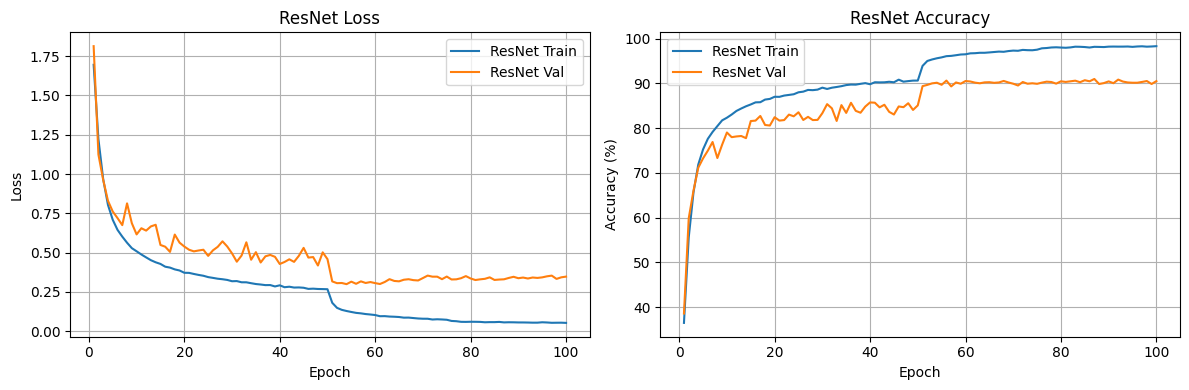

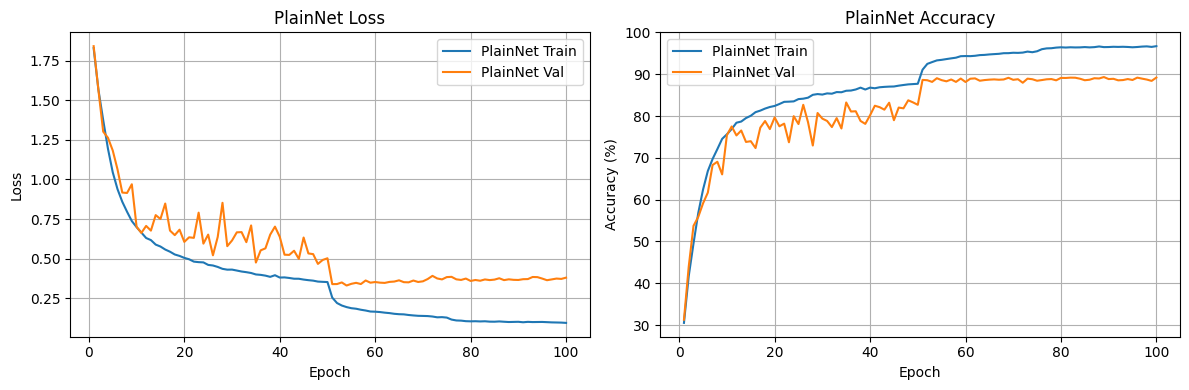

In [23]:
def plot_curves(history, label):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label=f'{label} Train')
    plt.plot(epochs, history['val_loss'], label=f'{label} Val')
    plt.title(f'{label} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label=f'{label} Train')
    plt.plot(epochs, history['val_acc'], label=f'{label} Val')
    plt.title(f'{label} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot for both networks
plot_curves(resnet_history, "ResNet")
plot_curves(plainnet_history, "PlainNet")

In [26]:
# Class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def show_misclassified(model, loader, device, max_images=10):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            mismatches = preds != targets
            if mismatches.any():
                for i in range(inputs.size(0)):
                    if mismatches[i]:
                        misclassified.append((inputs[i].cpu(), preds[i].cpu().item(), targets[i].cpu().item()))
                    if len(misclassified) >= max_images:
                        break
            if len(misclassified) >= max_images:
                break

    if not misclassified:
        print("No misclassified images found.")
        return

    # Plot
    plt.figure(figsize=(15, 6))
    for i, (img, pred, label) in enumerate(misclassified):
        img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)  # unnormalize
        img = torch.clamp(img, 0, 1)
        plt.subplot(2, (max_images + 1) // 2, i + 1)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(f"True: {classes[label]}\nPred: {classes[pred]}", color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


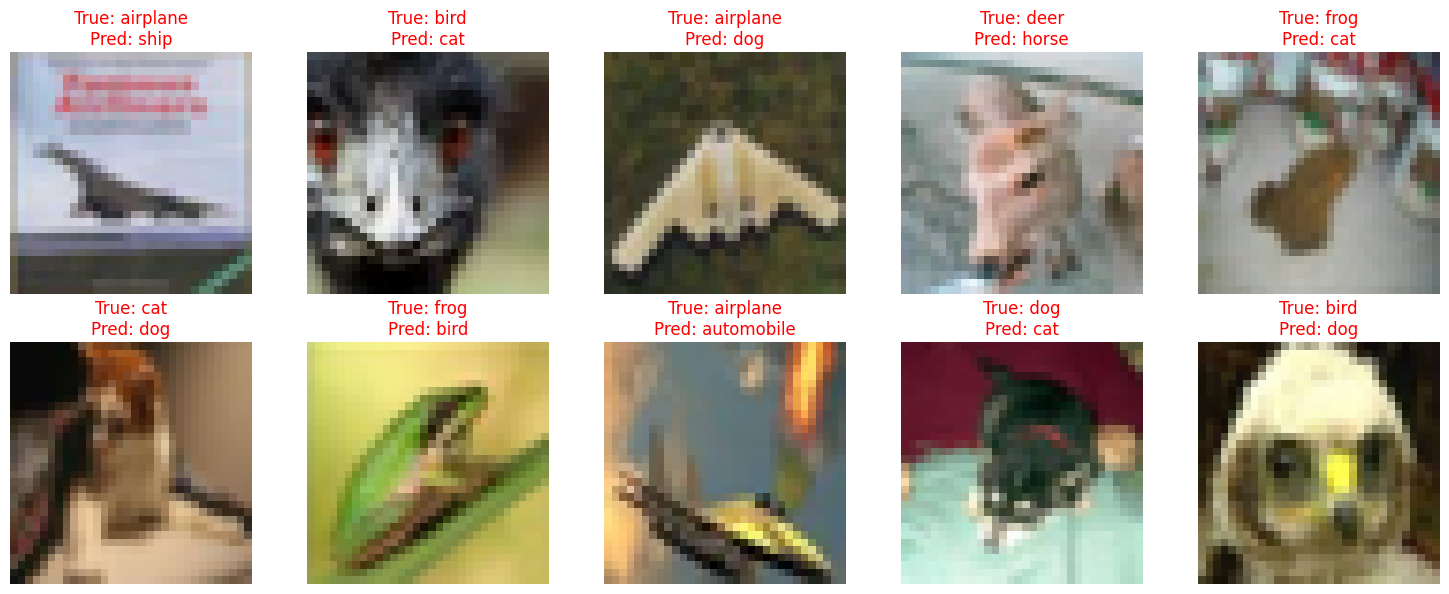

In [27]:
show_misclassified(resnet, test_loader, device, max_images=10)